# Imports

In [1]:
!pip install shap
!pip install deap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 3.0 MB/s eta 0:00:00


In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import numpy as np
import plotly.express as ex
import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
import plotly.offline as pyo
import pandas as pd

In [4]:
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
import seaborn as sns
from sklearn.metrics import roc_curve

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from scipy.stats import mode
import shap
import seaborn as sns
from sklearn.feature_selection import SelectKBest, f_classif
from deap import base, creator, tools, algorithms

# Load data

In [40]:
!wget https://www.dropbox.com/scl/fi/5gjugulccjigj0f8pmyjr/kaggle.json?rlkey=epjka756prhhkuoc9o9spxo18&st=ntg41kel&dl=0

--2024-08-06 12:05:10--  https://www.dropbox.com/scl/fi/5gjugulccjigj0f8pmyjr/kaggle.json?rlkey=epjka756prhhkuoc9o9spxo18
Resolving www.dropbox.com (www.dropbox.com)... 162.125.85.18, 2620:100:6035:18::a27d:5512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.85.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://uc1641cf3139bb5825565b8332d1.dl.dropboxusercontent.com/cd/0/inline/CYGLJzmuWoPQc2n2sgFZdhadpwdtwvA-Z5k6pikKxRajqqNKhS308IsKr7KpQLwT6FdCW4QK1DCx4pSwXwPsOvxbfyVSoV1hRvOV_5nMXObIsPlSP8RB0894uptsZ_b5unEiyf7qpYEUt-l_w9t-UiOg/file# [following]
--2024-08-06 12:05:11--  https://uc1641cf3139bb5825565b8332d1.dl.dropboxusercontent.com/cd/0/inline/CYGLJzmuWoPQc2n2sgFZdhadpwdtwvA-Z5k6pikKxRajqqNKhS308IsKr7KpQLwT6FdCW4QK1DCx4pSwXwPsOvxbfyVSoV1hRvOV_5nMXObIsPlSP8RB0894uptsZ_b5unEiyf7qpYEUt-l_w9t-UiOg/file
Resolving uc1641cf3139bb5825565b8332d1.dl.dropboxusercontent.com (uc1641cf3139bb5825565b8332d1.dl.dropboxusercontent.com)... 162.125.1.15, 2620

In [7]:
!pip install kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [8]:
!kaggle datasets download -d nageshsingh/dna-sequence-dataset
!unzip dna-sequence-dataset.zip

Dataset URL: https://www.kaggle.com/datasets/nageshsingh/dna-sequence-dataset
License(s): unknown
 66% 1.00M/1.51M [00:00<00:00, 1.45MB/s]
100% 1.51M/1.51M [00:00<00:00, 1.98MB/s]
Archive:  dna-sequence-dataset.zip
  inflating: chimpanzee.txt          
  inflating: dog.txt                 
  inflating: example_dna.fa          
  inflating: human.txt               


In [81]:
human = pd.read_table('/content/human.txt')
chimp = pd.read_table('/content/chimpanzee.txt')
dog = pd.read_table('/content/dog.txt')


# Convert sequence strings into k-mer words

In [82]:
# function to convert sequence strings into k-mer words, default size = 6 (hexamer words)
def getKmers(sequence, size=6):
    return [sequence[x:x+size].lower() for x in range(len(sequence) - size + 1)]

In [83]:
def missing_check(arr):
    classat=[]
    seqat=[]
    count = 0
    for i in range(0,len(arr)):
        if arr['sequence'][i]=='':
            seqat.append(i)
            count = count + 1
        if arr['class'][i]=='' or arr['class'][i]>6:
            classat.append(i)
            count = count + 1
    if count==0:
        print('No missing value')
    else:
        print('missing count = ',count)

# EDA

## Human

In [12]:
human.head(5)

,sequence,class
0,ATGCCCCAACTAAATACTACCGTATGGCCCACCATAATTACCCCCA...,4
1,ATGAACGAAAATCTGTTCGCTTCATTCATTGCCCCCACAATCCTAG...,4
2,ATGTGTGGCATTTGGGCGCTGTTTGGCAGTGATGATTGCCTTTCTG...,3
3,ATGTGTGGCATTTGGGCGCTGTTTGGCAGTGATGATTGCCTTTCTG...,3
4,ATGCAACAGCATTTTGAATTTGAATACCAGACCAAAGTGGATGGTG...,3


In [84]:
# Check and handle missing data or incorrect class values
human['sequence'].replace('', np.nan, inplace=True)
human.dropna(subset=['sequence', 'class'], inplace=True)
human['class'] = human['class'].apply(lambda x: x if x <= 6 else np.nan)
human.dropna(subset=['class'], inplace=True)

In [85]:
# Encode sequences
encoder = {char: idx for idx, char in enumerate('ATCGN')}
encoded_sequences = human['sequence'].apply(lambda x: [encoder[char] for char in x]).tolist()

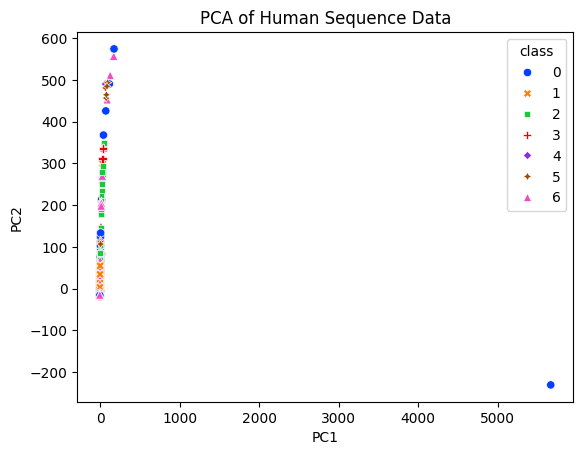

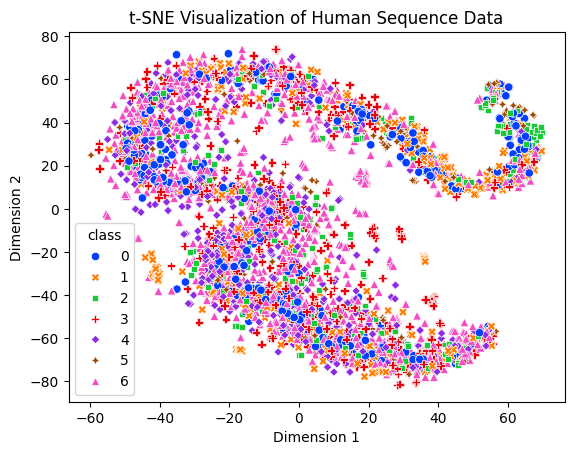

In [86]:
# Load the human dataset
human = pd.read_csv('/content/human.txt', delimiter='\t')

# Check and handle missing data or incorrect class values
human['sequence'].replace('', np.nan, inplace=True)
human.dropna(subset=['sequence', 'class'], inplace=True)
human['class'] = human['class'].apply(lambda x: x if x <= 6 else np.nan)
human.dropna(subset=['class'], inplace=True)

# Compute the lengths of the sequences
human['length'] = human['sequence'].apply(len)

# Encode sequences
encoder = {char: idx for idx, char in enumerate('ATCGN')}
encoded_sequences = human['sequence'].apply(lambda x: [encoder[char] for char in x]).tolist()

# Padding sequences to the maximum length
max_len = max(human['length'])
padded_sequences = np.array([seq + [np.nan]*(max_len-len(seq)) for seq in encoded_sequences])
padded_sequences = np.nan_to_num(padded_sequences)

# Scaling the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(padded_sequences)

# PCA for visualization
pca = PCA(n_components=2)
principal_components = pca.fit_transform(X_scaled)
principal_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
principal_df['class'] = human['class']

sns.scatterplot(data=principal_df, x='PC1', y='PC2', hue='class', style='class', palette='bright')
plt.title('PCA of Human Sequence Data')
plt.show()

# t-SNE Visualization
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(X_scaled)
tsne_df = pd.DataFrame(data=tsne_results, columns=['Dimension 1', 'Dimension 2'])
tsne_df['class'] = human['class']

sns.scatterplot(data=tsne_df, x='Dimension 1', y='Dimension 2', hue='class', style='class', palette='bright')
plt.title('t-SNE Visualization of Human Sequence Data')
plt.show()

<Axes: xlabel='class'>

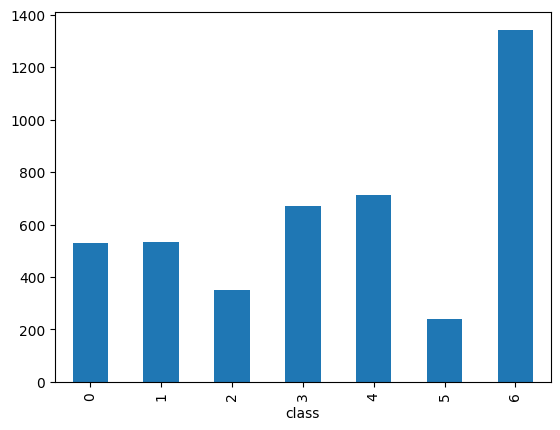

In [16]:
human['class'].value_counts().sort_index().plot.bar()

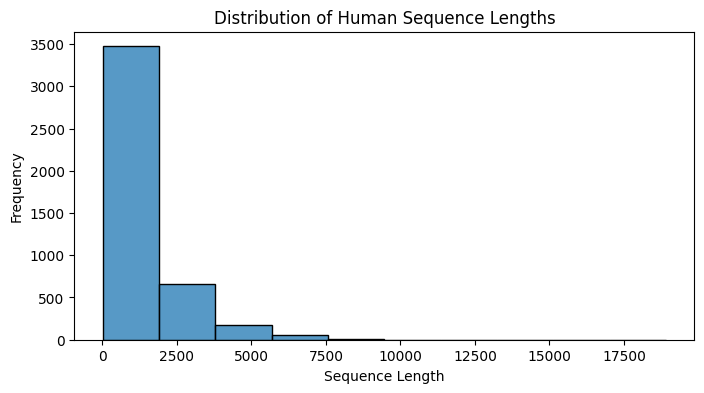

In [17]:
# Sequence Length Distribution
human['length'] = human['sequence'].apply(len)
plt.figure(figsize=(8, 4))
sns.histplot(human['length'], bins=10, kde=False)
plt.title('Distribution of Human Sequence Lengths')
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.show()

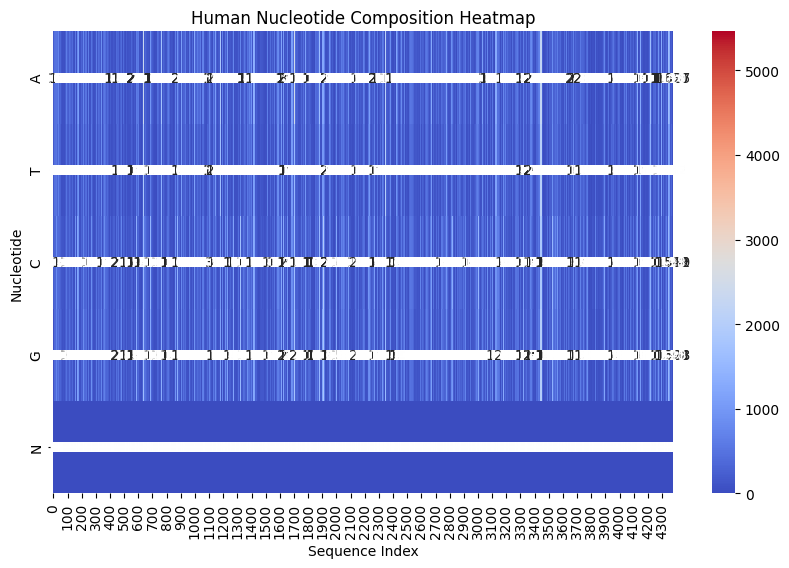

In [ ]:
# Heatmap of Sequence Composition
def nucleotide_composition(seq):
    return pd.Series({'A': seq.count('A'), 'T': seq.count('T'), 'C': seq.count('C'), 'G': seq.count('G'), 'N': seq.count('N')})

comp_df = human['sequence'].apply(nucleotide_composition)
plt.figure(figsize=(10, 6))
sns.heatmap(comp_df.T, annot=True, cmap='coolwarm', fmt="d")
plt.title('Human Nucleotide Composition Heatmap')
plt.ylabel('Nucleotide')
plt.xlabel('Sequence Index')
plt.show()

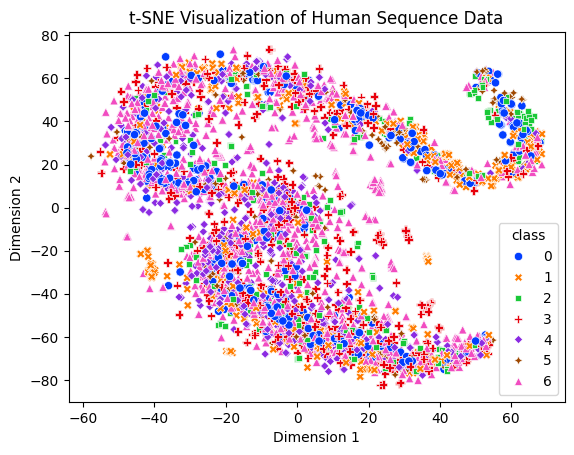

In [ ]:
# t-SNE Visualization
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(X_scaled)
tsne_df = pd.DataFrame(data = tsne_results, columns = ['Dimension 1', 'Dimension 2'])
tsne_df['class'] = human['class']

sns.scatterplot(data=tsne_df, x='Dimension 1', y='Dimension 2', hue='class', style='class', palette='bright')
plt.title('t-SNE Visualization of Human Sequence Data')
plt.show()


## Chimp

In [18]:
chimp.head()

,sequence,class
0,ATGCCCCAACTAAATACCGCCGTATGACCCACCATAATTACCCCCA...,4
1,ATGAACGAAAATCTATTCGCTTCATTCGCTGCCCCCACAATCCTAG...,4
2,ATGGCCTCGCGCTGGTGGCGGTGGCGACGCGGCTGCTCCTGGAGGC...,4
3,ATGGCCTCGCGCTGGTGGCGGTGGCGACGCGGCTGCTCCTGGAGGC...,4
4,ATGGGCAGCGCCAGCCCGGGTCTGAGCAGCGTGTCCCCCAGCCACC...,6


In [87]:
# Load the chimpanzee dataset
chimp = pd.read_table('/content/chimpanzee.txt')

# Check and handle missing data or incorrect class values
chimp['sequence'].replace('', np.nan, inplace=True)
chimp.dropna(subset=['sequence', 'class'], inplace=True)
chimp['class'] = chimp['class'].apply(lambda x: x if x <= 6 else np.nan)
chimp.dropna(subset=['class'], inplace=True)


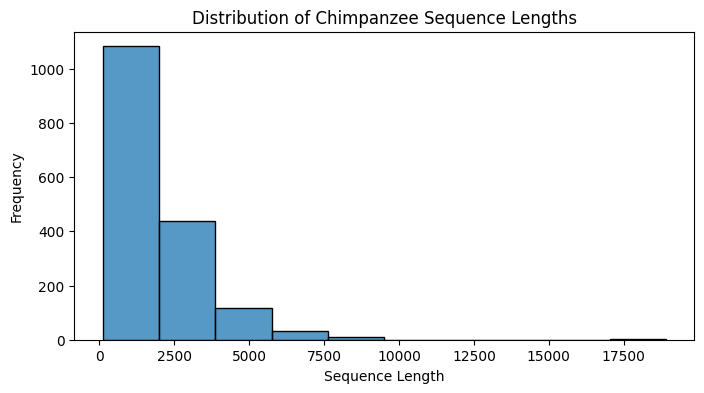

In [ ]:
# Sequence Length Distribution
chimp['length'] = chimp['sequence'].apply(len)
plt.figure(figsize=(8, 4))
sns.histplot(chimp['length'], bins=10, kde=False)
plt.title('Distribution of Chimpanzee Sequence Lengths')
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.show()

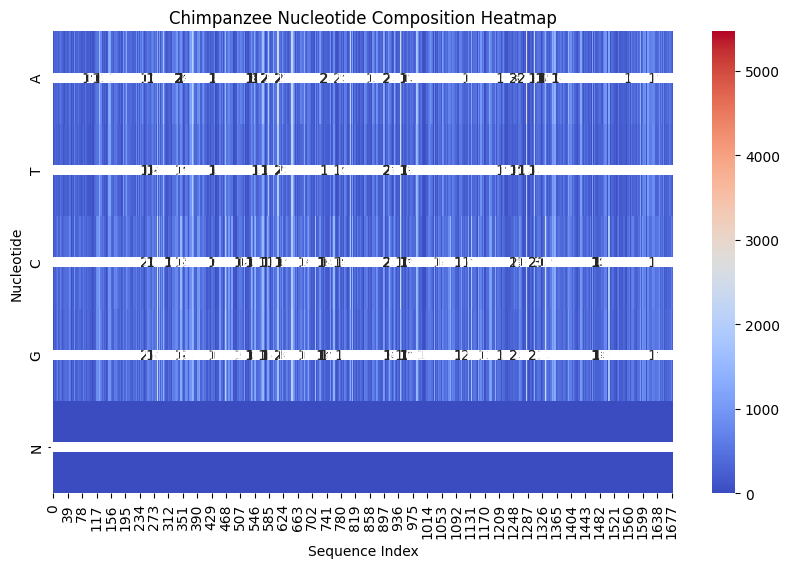

In [ ]:
# Heatmap of Sequence Composition
def nucleotide_composition(seq):
    return pd.Series({'A': seq.count('A'), 'T': seq.count('T'), 'C': seq.count('C'), 'G': seq.count('G'), 'N': seq.count('N')})

comp_df = chimp['sequence'].apply(nucleotide_composition)
plt.figure(figsize=(10, 6))
sns.heatmap(comp_df.T, annot=True, cmap='coolwarm', fmt="d")
plt.title('Chimpanzee Nucleotide Composition Heatmap')
plt.ylabel('Nucleotide')
plt.xlabel('Sequence Index')
plt.show()

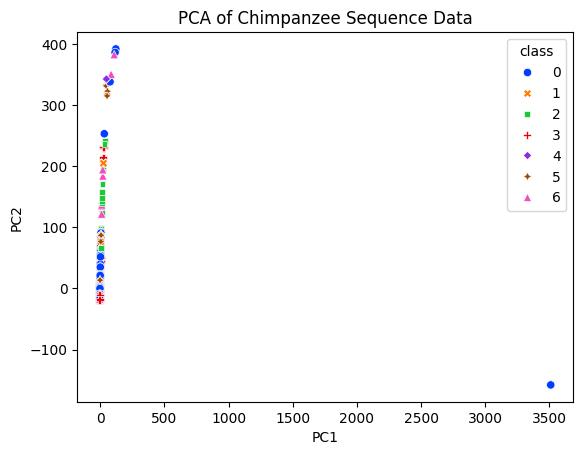

In [ ]:
# Principal Component Analysis (PCA)
encoder = {char: idx for idx, char in enumerate('ATCGN')}
encoded_sequences = chimp['sequence'].apply(lambda x: [encoder[char] for char in x]).to_list()
max_len = max(chimp['length'])
padded_sequences = np.array([i + [np.nan]*(max_len-len(i)) for i in encoded_sequences])
padded_sequences = np.nan_to_num(padded_sequences)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(padded_sequences)

pca = PCA(n_components=2)
principal_components = pca.fit_transform(X_scaled)
principal_df = pd.DataFrame(data = principal_components, columns = ['PC1', 'PC2'])
principal_df['class'] = chimp['class']

sns.scatterplot(data=principal_df, x='PC1', y='PC2', hue='class', style='class', palette='bright')
plt.title('PCA of Chimpanzee Sequence Data')
plt.show()




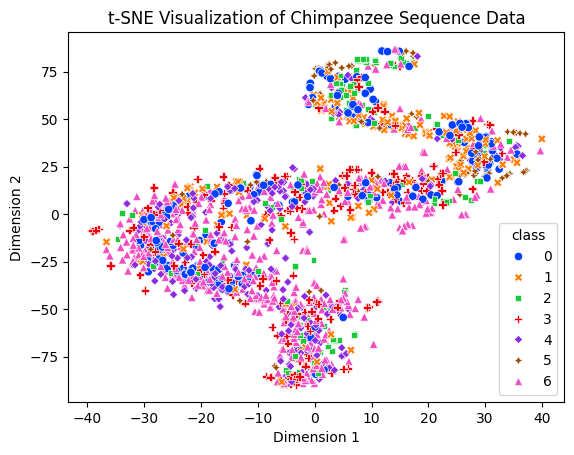

In [ ]:
# t-SNE Visualization
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(X_scaled)
tsne_df = pd.DataFrame(data = tsne_results, columns = ['Dimension 1', 'Dimension 2'])
tsne_df['class'] = chimp['class']

sns.scatterplot(data=tsne_df, x='Dimension 1', y='Dimension 2', hue='class', style='class', palette='bright')
plt.title('t-SNE Visualization of Chimpanzee Sequence Data')
plt.show()

<Axes: xlabel='class'>

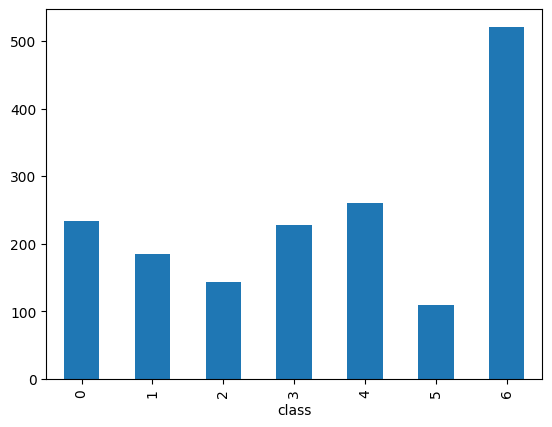

In [ ]:
chimp['class'].value_counts().sort_index().plot.bar()

## Dog

In [20]:
dog.head()

,sequence,class
0,ATGCCACAGCTAGATACATCCACCTGATTTATTATAATCTTTTCAA...,4
1,ATGAACGAAAATCTATTCGCTTCTTTCGCTGCCCCCTCAATAATAG...,4
2,ATGGAAACACCCTTCTACGGCGATGAGGCGCTGAGCGGCCTGGGCG...,6
3,ATGTGCACTAAAATGGAACAGCCCTTCTACCACGACGACTCATACG...,6
4,ATGAGCCGGCAGCTAAACAGAAGCCAGAACTGCTCCTTCAGTGACG...,0


In [88]:
# Check and handle missing data or incorrect class values
dog['sequence'].replace('', np.nan, inplace=True)
dog.dropna(subset=['sequence', 'class'], inplace=True)
dog['class'] = dog['class'].apply(lambda x: x if x <= 6 else np.nan)
dog.dropna(subset=['class'], inplace=True)

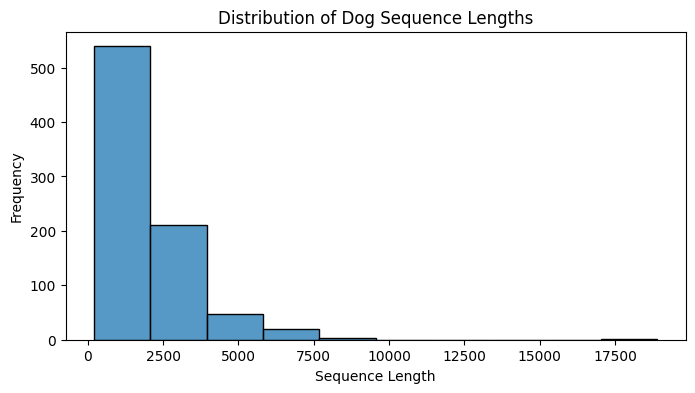

In [ ]:
# Sequence Length Distribution
dog['length'] = dog['sequence'].apply(len)
plt.figure(figsize=(8, 4))
sns.histplot(dog['length'], bins=10, kde=False)
plt.title('Distribution of Dog Sequence Lengths')
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.show()



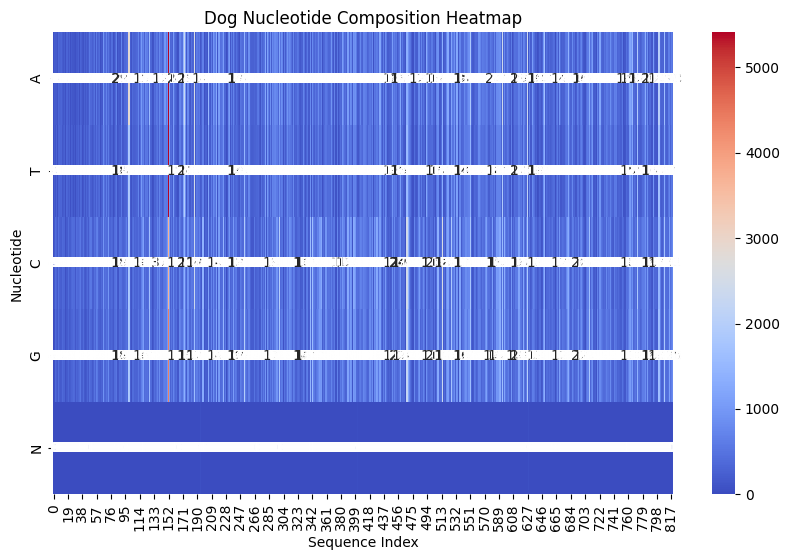

In [ ]:
# Heatmap of Sequence Composition
def nucleotide_composition(seq):
    return pd.Series({'A': seq.count('A'), 'T': seq.count('T'), 'C': seq.count('C'), 'G': seq.count('G'), 'N': seq.count('N')})

comp_df = dog['sequence'].apply(nucleotide_composition)
plt.figure(figsize=(10, 6))
sns.heatmap(comp_df.T, annot=True, cmap='coolwarm', fmt="d")
plt.title('Dog Nucleotide Composition Heatmap')
plt.ylabel('Nucleotide')
plt.xlabel('Sequence Index')
plt.show()



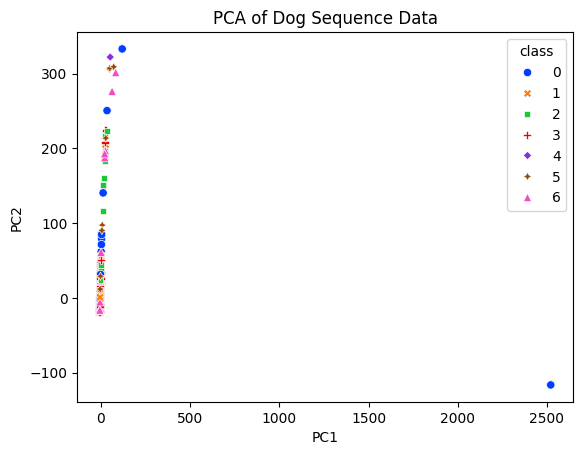

In [ ]:
# Principal Component Analysis (PCA)
encoder = {char: idx for idx, char in enumerate('ATCGN')}
encoded_sequences = dog['sequence'].apply(lambda x: [encoder[char] for char in x]).to_list()
max_len = max(dog['length'])
padded_sequences = np.array([i + [np.nan]*(max_len-len(i)) for i in encoded_sequences])
padded_sequences = np.nan_to_num(padded_sequences)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(padded_sequences)

pca = PCA(n_components=2)
principal_components = pca.fit_transform(X_scaled)
principal_df = pd.DataFrame(data = principal_components, columns = ['PC1', 'PC2'])
principal_df['class'] = dog['class']

sns.scatterplot(data=principal_df, x='PC1', y='PC2', hue='class', style='class', palette='bright')
plt.title('PCA of Dog Sequence Data')
plt.show()



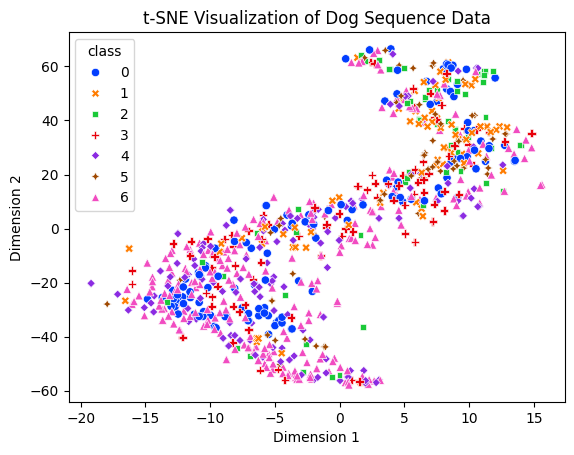

In [ ]:
# t-SNE Visualization
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(X_scaled)
tsne_df = pd.DataFrame(data = tsne_results, columns = ['Dimension 1', 'Dimension 2'])
tsne_df['class'] = dog['class']

sns.scatterplot(data=tsne_df, x='Dimension 1', y='Dimension 2', hue='class', style='class', palette='bright')
plt.title('t-SNE Visualization of Dog Sequence Data')
plt.show()

<Axes: xlabel='class'>

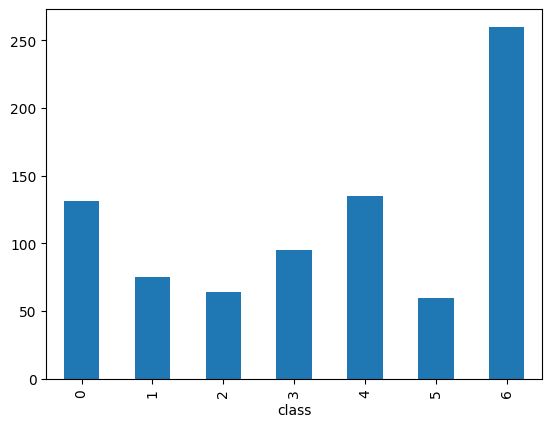

In [ ]:
dog['class'].value_counts().sort_index().plot.bar()

## ALL Species together

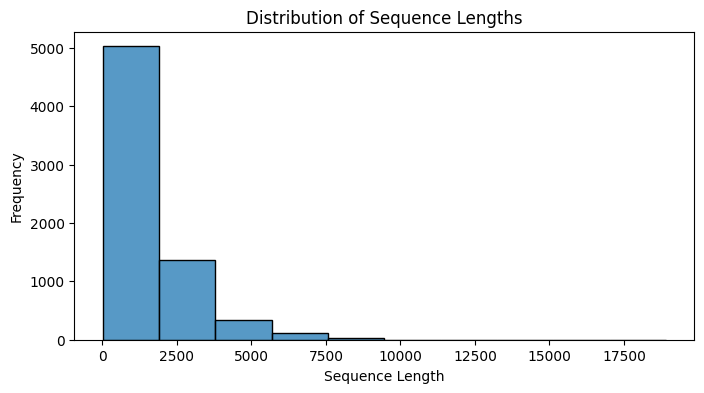

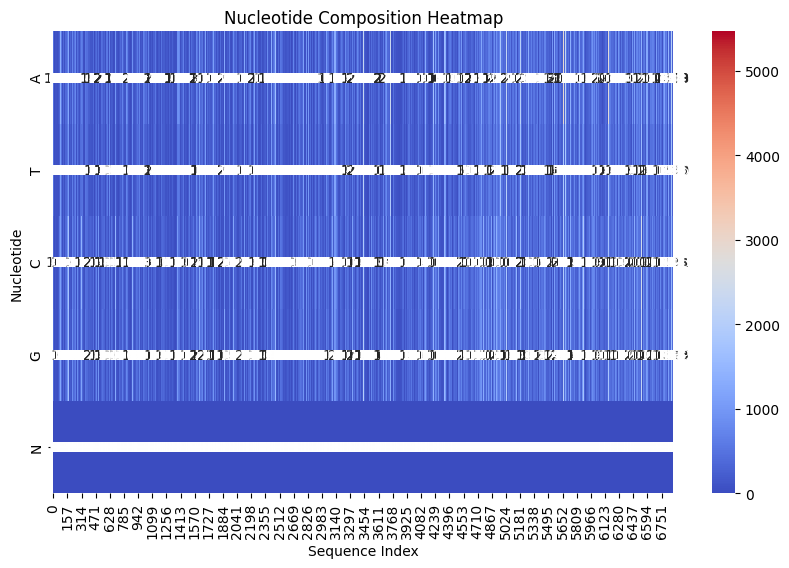

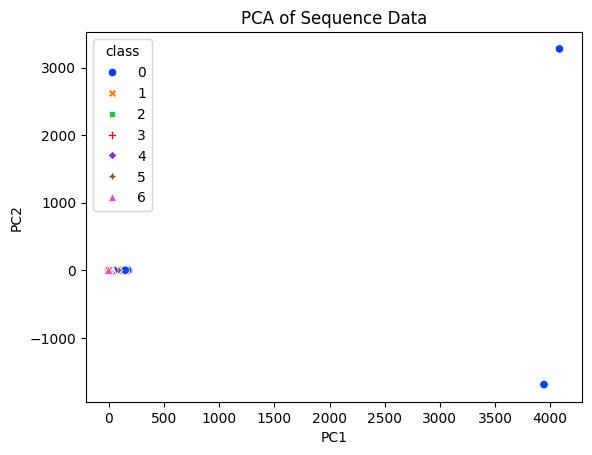

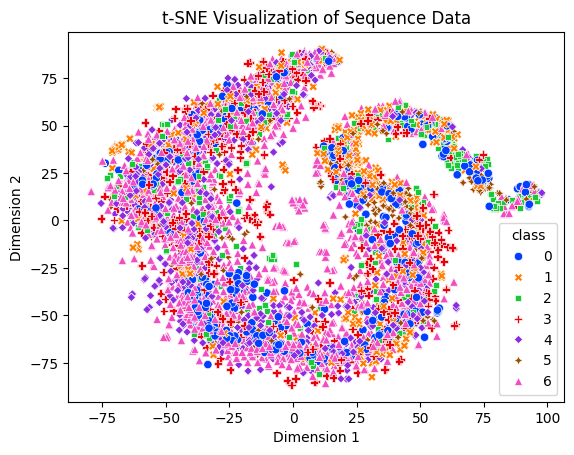

In [47]:
# Load the datasets
human = pd.read_table('/content/human.txt')
chimp = pd.read_table('/content/chimpanzee.txt')
dog = pd.read_table('/content/dog.txt')

# Assuming 'sequence' and 'class' columns are present in these datasets
# Combining datasets for analysis
data = pd.concat([human, chimp, dog], ignore_index=True)

# Check for missing values and replace empty sequences or incorrect classes
data['sequence'].replace('', np.nan, inplace=True)
data.dropna(subset=['sequence', 'class'], inplace=True)
data['class'] = data['class'].apply(lambda x: x if x <= 6 else np.nan)
data.dropna(subset=['class'], inplace=True)

# Function to convert sequence strings into k-mer words, default size = 6 (hexamer words)
def getKmers(sequence, size=6):
    return [sequence[x:x+size].lower() for x in range(len(sequence) - size + 1)]

# Apply k-mer conversion
data['kmers'] = data['sequence'].apply(getKmers)

# Sequence Length Distribution
data['length'] = data['sequence'].apply(len)
plt.figure(figsize=(8, 4))
sns.histplot(data['length'], bins=10, kde=False)
plt.title('Distribution of Sequence Lengths')
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.show()

# Heatmap of Sequence Composition
def nucleotide_composition(seq):
    return pd.Series({'A': seq.count('A'), 'T': seq.count('T'), 'C': seq.count('C'), 'G': seq.count('G'), 'N': seq.count('N')})

comp_df = data['sequence'].apply(nucleotide_composition)
plt.figure(figsize=(10, 6))
sns.heatmap(comp_df.T, annot=True, cmap='coolwarm', fmt="d")
plt.title('Nucleotide Composition Heatmap')
plt.ylabel('Nucleotide')
plt.xlabel('Sequence Index')
plt.show()

# Encoding sequences for PCA and t-SNE, including 'N'
encoder = {char: idx for idx, char in enumerate('ATCGN')}
encoded_sequences = data['sequence'].apply(lambda x: [encoder[char] for char in x]).to_list()
max_len = max(data['length'])
padded_sequences = np.array([i + [np.nan]*(max_len-len(i)) for i in encoded_sequences])
padded_sequences = np.nan_to_num(padded_sequences)

# Standardizing the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(padded_sequences)

# Running PCA
pca = PCA(n_components=2)
principal_components = pca.fit_transform(X_scaled)
principal_df = pd.DataFrame(data = principal_components, columns = ['PC1', 'PC2'])
principal_df['class'] = data['class']

# Plot PCA results
sns.scatterplot(data=principal_df, x='PC1', y='PC2', hue='class', style='class', palette='bright')
plt.title('PCA of Sequence Data')
plt.show()

# t-SNE Visualization
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(X_scaled)
tsne_df = pd.DataFrame(data = tsne_results, columns = ['Dimension 1', 'Dimension 2'])
tsne_df['class'] = data['class']

# Plot t-SNE results
sns.scatterplot(data=tsne_df, x='Dimension 1', y='Dimension 2', hue='class', style='class', palette='bright')
plt.title('t-SNE Visualization of Sequence Data')
plt.show()


# Preprocessing

In [89]:
human['words'] = human.apply(lambda x: getKmers(x['sequence']), axis=1)
human = human.drop('sequence', axis=1)
chimp['words'] = chimp.apply(lambda x: getKmers(x['sequence']), axis=1)
chimp = chimp.drop('sequence', axis=1)
dog['words'] = dog.apply(lambda x: getKmers(x['sequence']), axis=1)
dog = dog.drop('sequence', axis=1)

In [90]:
print(human['words'][0])

['atgccc', 'tgcccc', 'gcccca', 'ccccaa', 'cccaac', 'ccaact', 'caacta', 'aactaa', 'actaaa', 'ctaaat', 'taaata', 'aaatac', 'aatact', 'atacta', 'tactac', 'actacc', 'ctaccg', 'taccgt', 'accgta', 'ccgtat', 'cgtatg', 'gtatgg', 'tatggc', 'atggcc', 'tggccc', 'ggccca', 'gcccac', 'cccacc', 'ccacca', 'caccat', 'accata', 'ccataa', 'cataat', 'ataatt', 'taatta', 'aattac', 'attacc', 'ttaccc', 'tacccc', 'accccc', 'ccccca', 'ccccat', 'cccata', 'ccatac', 'catact', 'atactc', 'tactcc', 'actcct', 'ctcctt', 'tcctta', 'ccttac', 'cttaca', 'ttacac', 'tacact', 'acacta', 'cactat', 'actatt', 'ctattc', 'tattcc', 'attcct', 'ttcctc', 'tcctca', 'cctcat', 'ctcatc', 'tcatca', 'catcac', 'atcacc', 'tcaccc', 'caccca', 'acccaa', 'cccaac', 'ccaact', 'caacta', 'aactaa', 'actaaa', 'ctaaaa', 'taaaaa', 'aaaaat', 'aaaata', 'aaatat', 'aatatt', 'atatta', 'tattaa', 'attaaa', 'ttaaac', 'taaaca', 'aaacac', 'aacaca', 'acacaa', 'cacaaa', 'acaaac', 'caaact', 'aaacta', 'aactac', 'actacc', 'ctacca', 'taccac', 'accacc', 'ccacct', 'caccta',

In [91]:
human_texts = list(human['words'])
for item in range(len(human_texts)):
    human_texts[item] = ' '.join(human_texts[item])
y_h = human.iloc[:, 0].values

In [92]:
y_h
len(y_h)

4380

In [93]:
chimp_texts = list(chimp['words'])
for item in range(len(chimp_texts)):
    chimp_texts[item] = ' '.join(chimp_texts[item])
y_c = chimp.iloc[:, 0].values                       # y_c for chimp

In [94]:
dog_texts = list(dog['words'])
for item in range(len(dog_texts)):
    dog_texts[item] = ' '.join(dog_texts[item])
y_d = dog.iloc[:, 0].values  #y_d for dog

In [95]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(ngram_range=(4,4))
X = cv.fit_transform(human_texts)
X_chimp = cv.transform(chimp_texts)
X_dog = cv.transform(dog_texts)

In [96]:
print(X.shape)
print(X_chimp.shape)
print(X_dog.shape)

(4380, 232414)
(1682, 232414)
(820, 232414)


# Machine Learning

In [97]:
def get_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    return accuracy, precision, recall, f1


# Human

In [98]:
# Splitting the human dataset into the training set and test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y_h,
                                                    test_size = 0.20,
                                                    random_state=42)

In [99]:
print(X_train.shape)
print(X_test.shape)

(3504, 232414)
(876, 232414)


### MultinomialNB

In [109]:
from sklearn.naive_bayes import MultinomialNB
classifier = MultinomialNB(alpha=0.01)
classifier.fit(X_train, y_train)

MultinomialNB(alpha=0.01)

In [110]:
y_pred = classifier.predict(X_test)

In [111]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
print("Confusion matrix\n")
print(pd.crosstab(pd.Series(y_test, name='Actual'), pd.Series(y_pred, name='Predicted')))
def get_metrics(y_test, y_predicted):
    accuracy = accuracy_score(y_test, y_predicted)
    precision = precision_score(y_test, y_predicted, average='weighted')
    recall = recall_score(y_test, y_predicted, average='weighted')
    f1 = f1_score(y_test, y_predicted, average='weighted')
    return accuracy, precision, recall, f1
accuracy, precision, recall, f1 = get_metrics(y_test, y_pred)
print("accuracy = %.3f \nprecision = %.3f \nrecall = %.3f \nf1 = %.3f" % (accuracy, precision, recall, f1))

Confusion matrix

Predicted   0    1   2    3    4   5    6
Actual                                   
0          99    0   0    0    0   0    3
1           0  100   0    0    0   0    6
2           0    0  78    0    0   0    0
3           0    0   0  122    0   0    3
4           0    0   0    0  143   0    6
5           0    0   0    0    0  51    0
6           0    0   0    0    0   0  265
accuracy = 0.979 
precision = 0.981 
recall = 0.979 
f1 = 0.980


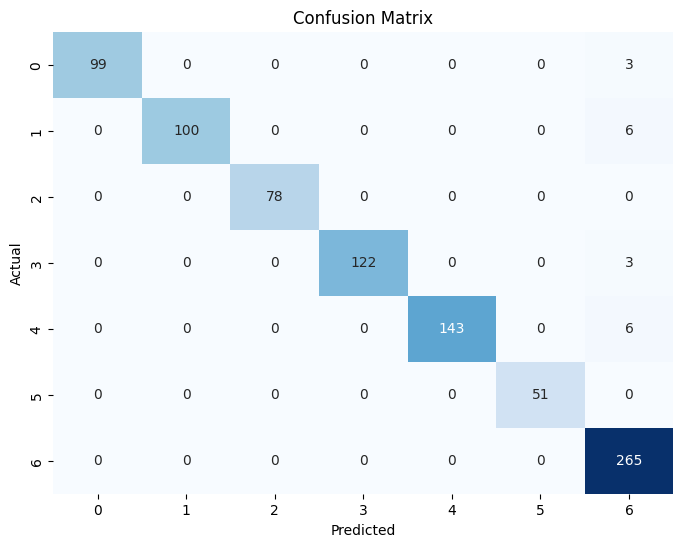

In [112]:
# Calculate the confusion matrix
conf_matrix = pd.crosstab(pd.Series(y_test, name='Actual'), pd.Series(y_pred, name='Predicted'))

# Plot the confusion matrix using Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [33]:
!pip install pyswarms

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 3.4 MB/s eta 0:00:00


# def AHA_optimizer

In [75]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from scipy.sparse import issparse

def AHA_optimizer(X, y, n_iterations=50, n_hummingbirds=10, n_clusters=3):
    if issparse(X):
        X = X.toarray()

    def initialize_hummingbirds(n_hummingbirds, n_clusters, data):
        hummingbirds = []
        for _ in range(n_hummingbirds):
            km = KMeans(n_clusters=n_clusters, init='k-means++', n_init=1, random_state=42)
            km.fit(data)
            centroids = km.cluster_centers_
            hummingbirds.append({'position': centroids, 'fitness': np.inf})
        return hummingbirds

    def axial_flight(centroids, data):
        perturbation = np.random.randn(*centroids.shape) * 0.01
        new_centroids = np.clip(centroids + perturbation,
                                np.min(data, axis=0)[None, :],
                                np.max(data, axis=0)[None, :])
        return new_centroids

    def diagonal_flight(centroids, data):
        perturbation = np.random.randn(*centroids.shape) * 0.1
        new_centroids = np.clip(centroids + perturbation, np.min(data, axis=0), np.max(data, axis=0))
        return new_centroids

    def omnidirectional_flight(centroids, data):
        new_centroids = data[np.random.choice(data.shape[0], centroids.shape[0], replace=False), :]
        return new_centroids

    def update_position(hummingbird, data, flight_type):
        if flight_type == "axial":
            new_position = axial_flight(hummingbird['position'], data)
        elif flight_type == "diagonal":
            new_position = diagonal_flight(hummingbird['position'], data)
        else:  # Omnidirectional flight
            new_position = omnidirectional_flight(hummingbird['position'], data)
        return new_position

    def evaluate_solution(y_true, y_pred):
        return -adjusted_rand_score(y_true, y_pred)

    def choose_flight_type():
        r = np.random.rand()
        if r < 0.5:
            return "axial"
        elif r < 0.75:
            return "diagonal"
        else:
            return "omnidirectional"

    hummingbirds = initialize_hummingbirds(n_hummingbirds, n_clusters, X)
    best_global_fitness = np.inf
    best_global_position = None

    for iteration in range(n_iterations):
        for hummingbird in hummingbirds:
            flight_type = choose_flight_type()
            new_position = update_position(hummingbird, X, flight_type)
            kmeans = KMeans(n_clusters=n_clusters, init=new_position, n_init=1, max_iter=20, random_state=42)
            y_pred = kmeans.fit_predict(X)
            fitness = evaluate_solution(y, y_pred)

            if fitness < hummingbird['fitness']:
                hummingbird['position'] = new_position
                hummingbird['fitness'] = fitness

                if fitness < best_global_fitness:
                    best_global_fitness = fitness
                    best_global_position = new_position

    return best_global_position, best_global_fitness


# def PSO_optimizer

In [76]:

from scipy.sparse import issparse

def PSO_optimizer(best_centroids, X, y, n_iterations=30, n_particles=20, w=0.7, c1=1.5, c2=1.5):
    if issparse(X):
        X = X.toarray()

    def initialize_particles(best_centroids, n_particles, data):
        particles = []
        for _ in range(n_particles):
            position = best_centroids + np.random.randn(*best_centroids.shape) * 0.1
            velocity = np.zeros_like(position)
            pbest_position = position.copy()
            pbest_fitness = np.inf
            particles.append({
                'position': position,
                'velocity': velocity,
                'pbest_position': pbest_position,
                'pbest_fitness': pbest_fitness
            })
        return particles

    def update_velocity(particle, gbest_position, w, c1, c2):
        r1, r2 = np.random.rand(2)
        cognitive = c1 * r1 * (particle['pbest_position'] - particle['position'])
        social = c2 * r2 * (gbest_position - particle['position'])
        new_velocity = w * particle['velocity'] + cognitive + social
        particle['velocity'] = new_velocity

    def update_pso_position(particle, data):
        new_position = particle['position'] + particle['velocity']
        new_position = np.clip(new_position, np.min(data, axis=0), np.max(data, axis=0))
        particle['position'] = new_position

    def assign_clusters(X, centroids):
        distances = np.sqrt(((X - centroids[:, np.newaxis])**2).sum(axis=2))
        closest_centroids = np.argmin(distances, axis=0)
        return closest_centroids

    def evaluate_solution(y_true, y_pred):
        return -adjusted_rand_score(y_true, y_pred)

    particles = initialize_particles(best_centroids, n_particles, X)
    gbest_position = best_centroids
    gbest_fitness = np.inf

    for _ in range(n_iterations):
        for particle in particles:
            update_velocity(particle, gbest_position, w, c1, c2)
            update_pso_position(particle, X)
            y_pred = assign_clusters(X, particle['position'])
            fitness = evaluate_solution(y, y_pred)

            if fitness < particle['pbest_fitness']:
                particle['pbest_fitness'] = fitness
                particle['pbest_position'] = particle['position'].copy()

            if fitness < gbest_fitness:
                gbest_fitness = fitness
                gbest_position = particle['position'].copy()

    return gbest_position, gbest_fitness


# def hybrid_aha_pso

In [77]:
def hybrid_aha_pso(X, y, n_clusters=3, aha_iterations=50, aha_hummingbirds=10, pso_iterations=30, pso_particles=20):
    best_centroids_aha, best_fitness_aha = AHA_optimizer(X, y, aha_iterations, aha_hummingbirds, n_clusters)
    best_centroids_pso, best_fitness_pso = PSO_optimizer(best_centroids_aha, X, y, pso_iterations, pso_particles)

    if best_fitness_pso < best_fitness_aha:
        return best_centroids_pso, best_fitness_pso
    else:
        return best_centroids_aha, best_fitness_aha



## NB with optimizer (AHA _PSO)

Best Fitness Overall (ARI): 0.021694537545932
Confusion matrix

Predicted   0    1   2    3    4   5    6
Actual                                   
0          99    0   0    0    0   0    3
1           0  102   0    0    0   0    4
2           0    0  78    0    0   0    0
3           0    0   0  124    0   0    1
4           0    0   0    0  143   0    6
5           0    0   0    0    0  51    0
6           1    0   0    1    0   0  263
accuracy = 0.982 
precision = 0.982 
recall = 0.982 
f1 = 0.982


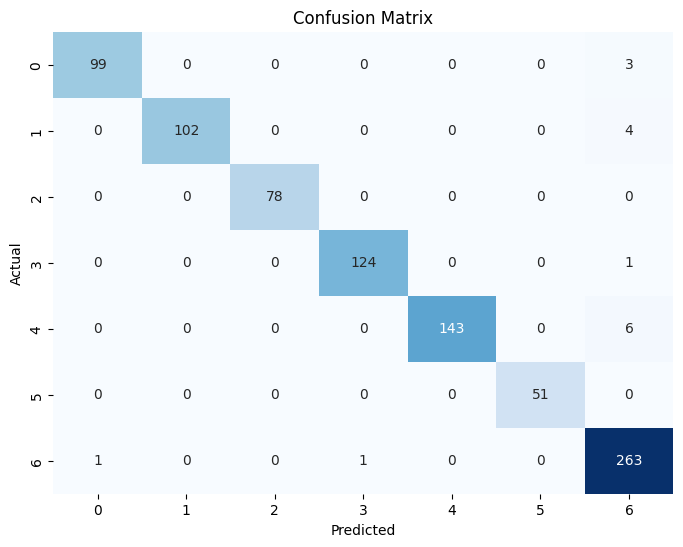

In [79]:
from sklearn.naive_bayes import MultinomialNB


# Use the hybrid optimizer to find the best centroids
best_centroids, best_fitness = hybrid_aha_pso(X_train, y_train, n_clusters=3, aha_iterations=25, aha_hummingbirds=10, pso_iterations=15, pso_particles=15)
print(f"Best Fitness Overall (ARI): {-best_fitness}")

# Train Naive Bayes Classifier using the optimized centroids
classifier = MultinomialNB(alpha=best_centroids[0][0])
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

# Evaluate the model
def get_metrics(y_test, y_predicted):
    accuracy = accuracy_score(y_test, y_predicted)
    precision = precision_score(y_test, y_predicted, average='weighted')
    recall = recall_score(y_test, y_predicted, average='weighted')
    f1 = f1_score(y_test, y_predicted, average='weighted')
    return accuracy, precision, recall, f1

accuracy, precision, recall, f1 = get_metrics(y_test, y_pred)
print("Confusion matrix\n")
conf_matrix = pd.crosstab(pd.Series(y_test, name='Actual'), pd.Series(y_pred, name='Predicted'))
print(conf_matrix)
print("accuracy = %.3f \nprecision = %.3f \nrecall = %.3f \nf1 = %.3f" % (accuracy, precision, recall, f1))

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


## Random Forest Classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# Random Forest Classifier
rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(X_train, y_train)
y_pred_rf = rf_classifier.predict(X_test)

In [ ]:
# Evaluate  models
accuracy_rf, precision_rf, recall_rf, f1_rf = get_metrics(y_test, y_pred_rf)

In [ ]:
print("\nRandom Forest Metrics:")
print("accuracy = %.3f \nprecision = %.3f \nrecall = %.3f \nf1 = %.3f" % (accuracy_rf, precision_rf, recall_rf, f1_rf))


Random Forest Metrics:
accuracy = 0.921 
precision = 0.928 
recall = 0.921 
f1 = 0.922


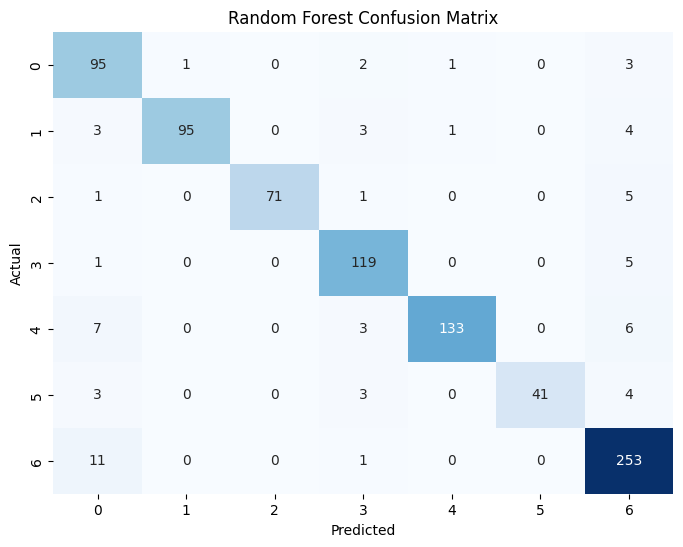

In [ ]:
# Confusion matrix for Random Forest
conf_matrix_rf = pd.crosstab(pd.Series(y_test, name='Actual'), pd.Series(y_pred_rf, name='Predicted'))
# Plot the confusion matrix for Random Forest using Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_rf, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Random Forest Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


## RF with optimizer (AHA _PSO)

Best Fitness Overall (ARI): 0.00013952643703335062
Confusion matrix

Predicted   0   1   2    3    4   5    6
Actual                                  
0          95   1   0    2    1   0    3
1           3  95   0    3    1   0    4
2           1   0  71    1    0   0    5
3           1   0   0  119    0   0    5
4           7   0   0    3  133   0    6
5           3   0   0    3    0  41    4
6          11   0   0    1    0   0  253
accuracy = 0.921 
precision = 0.928 
recall = 0.921 
f1 = 0.922


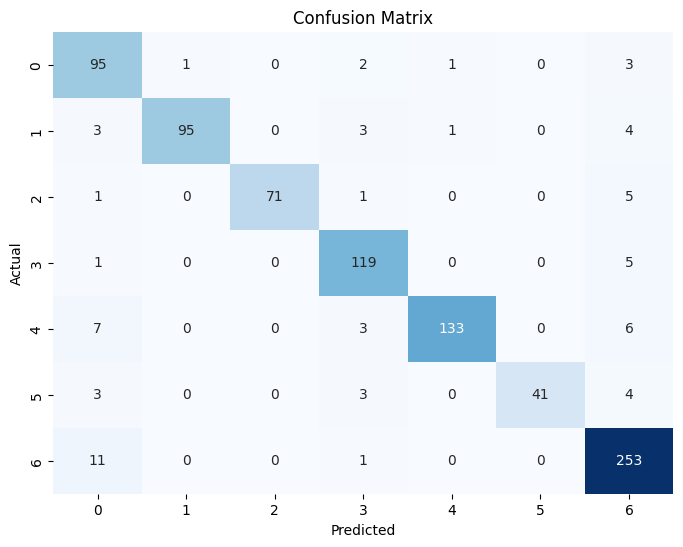

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Use the hybrid optimizer to find the best centroids
best_centroids, best_fitness = hybrid_aha_pso(X_train, y_train, n_clusters=3, aha_iterations=5, aha_hummingbirds=3, pso_iterations=3, pso_particles=3)
print(f"Best Fitness Overall (ARI): {-best_fitness}")

# Train Random Forest Classifier using the optimized centroids
classifier = RandomForestClassifier(random_state=42)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

# Evaluate the model
def get_metrics(y_test, y_predicted):
    accuracy = accuracy_score(y_test, y_predicted)
    precision = precision_score(y_test, y_predicted, average='weighted')
    recall = recall_score(y_test, y_predicted, average='weighted')
    f1 = f1_score(y_test, y_predicted, average='weighted')
    return accuracy, precision, recall, f1

accuracy, precision, recall, f1 = get_metrics(y_test, y_pred)
print("Confusion matrix\n")
conf_matrix = pd.crosstab(pd.Series(y_test, name='Actual'), pd.Series(y_pred, name='Predicted'))
print(conf_matrix)
print("accuracy = %.3f \nprecision = %.3f \nrecall = %.3f \nf1 = %.3f" % (accuracy, precision, recall, f1))

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


## SVM

In [ ]:
# Support Vector Machine (SVM)
svm_classifier = SVC(kernel='linear', random_state=42)
svm_classifier.fit(X_train, y_train)
y_pred_svm = svm_classifier.predict(X_test)

# Evaluate  model
accuracy_svm, precision_svm, recall_svm, f1_svm = get_metrics(y_test, y_pred_svm)

print("\nSVM Metrics:")
print("accuracy = %.3f \nprecision = %.3f \nrecall = %.3f \nf1 = %.3f" % (accuracy_svm, precision_svm, recall_svm, f1_svm))


SVM Metrics:
accuracy = 0.913 
precision = 0.926 
recall = 0.913 
f1 = 0.914


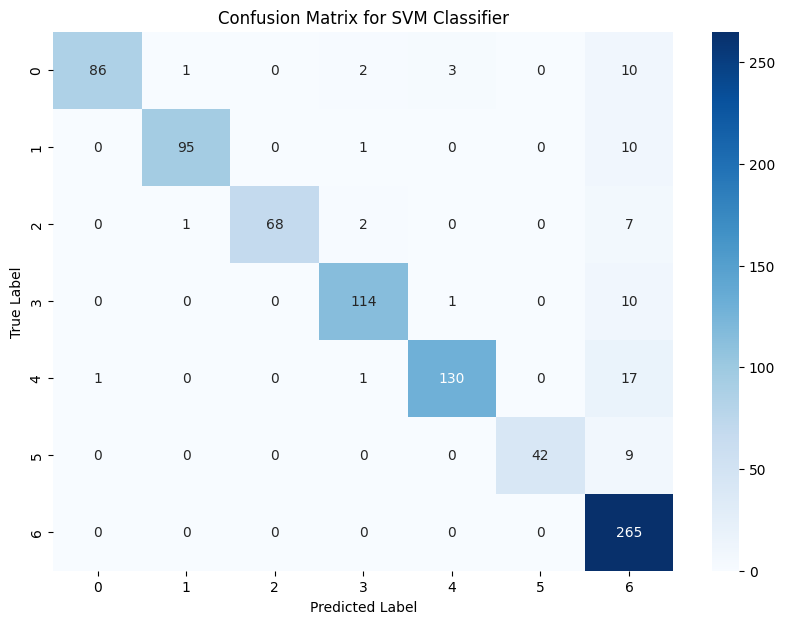

In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_svm)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.title('Confusion Matrix for SVM Classifier')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


In [ ]:
# Classification Report
report = classification_report(y_test, y_pred_svm)
print("\nClassification Report:\n", report)


Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.84      0.91       102
           1       0.98      0.90      0.94       106
           2       1.00      0.87      0.93        78
           3       0.95      0.91      0.93       125
           4       0.97      0.87      0.92       149
           5       1.00      0.82      0.90        51
           6       0.81      1.00      0.89       265

    accuracy                           0.91       876
   macro avg       0.96      0.89      0.92       876
weighted avg       0.93      0.91      0.91       876



## SVM with optimizer (AHA _PSO)

Best Fitness Overall (ARI): -0.0005118857069397849
Confusion matrix

Predicted   0   1   2    3    4   5    6
Actual                                  
0          86   1   0    2    3   0   10
1           0  95   0    1    0   0   10
2           0   1  68    2    0   0    7
3           0   0   0  114    1   0   10
4           1   0   0    1  130   0   17
5           0   0   0    0    0  42    9
6           0   0   0    0    0   0  265
accuracy = 0.913 
precision = 0.926 
recall = 0.913 
f1 = 0.914


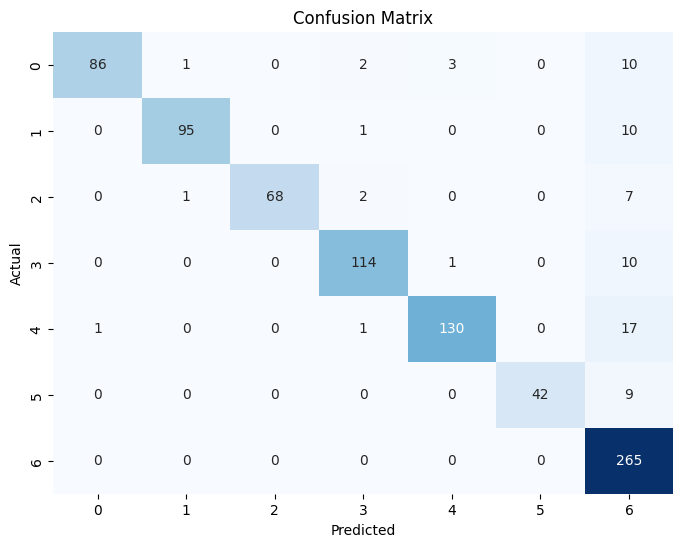

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Use the hybrid optimizer to find the best centroids
best_centroids, best_fitness = hybrid_aha_pso(X_train, y_train, n_clusters=3, aha_iterations=5, aha_hummingbirds=3, pso_iterations=3, pso_particles=2)
print(f"Best Fitness Overall (ARI): {-best_fitness}")

# Train SVM Classifier using the optimized centroids
classifier = SVC(kernel='linear', C=1, random_state=42)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

# Evaluate the model
def get_metrics(y_test, y_predicted):
    accuracy = accuracy_score(y_test, y_predicted)
    precision = precision_score(y_test, y_predicted, average='weighted')
    recall = recall_score(y_test, y_predicted, average='weighted')
    f1 = f1_score(y_test, y_predicted, average='weighted')
    return accuracy, precision, recall, f1

accuracy, precision, recall, f1 = get_metrics(y_test, y_pred)
print("Confusion matrix\n")
conf_matrix = pd.crosstab(pd.Series(y_test, name='Actual'), pd.Series(y_pred, name='Predicted'))
print(conf_matrix)
print("accuracy = %.3f \nprecision = %.3f \nrecall = %.3f \nf1 = %.3f" % (accuracy, precision, recall, f1))

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


# **Dog**

## MultinomialNB

In [116]:
y_pred_dog = classifier.predict(X_dog)

In [ ]:
# performance on dog genes
print("Confusion matrix\n")
print(pd.crosstab(pd.Series(y_d, name='Actual'), pd.Series(y_pred_dog, name='Predicted')))
accuracy, precision, recall, f1 = get_metrics(y_d, y_pred_dog)
print("accuracy = %.3f \nprecision = %.3f \nrecall = %.3f \nf1 = %.3f" % (accuracy, precision, recall, f1))

Confusion matrix

Predicted    0   1   2   3    4   5    6
Actual                                  
0          127   0   0   0    0   0    4
1            0  63   0   0    1   0   11
2            0   0  49   0    1   0   14
3            1   0   0  81    2   0   11
4            4   0   0   1  126   0    4
5            4   0   0   0    1  53    2
6            0   0   0   0    0   0  260
accuracy = 0.926 
precision = 0.934 
recall = 0.926 
f1 = 0.925


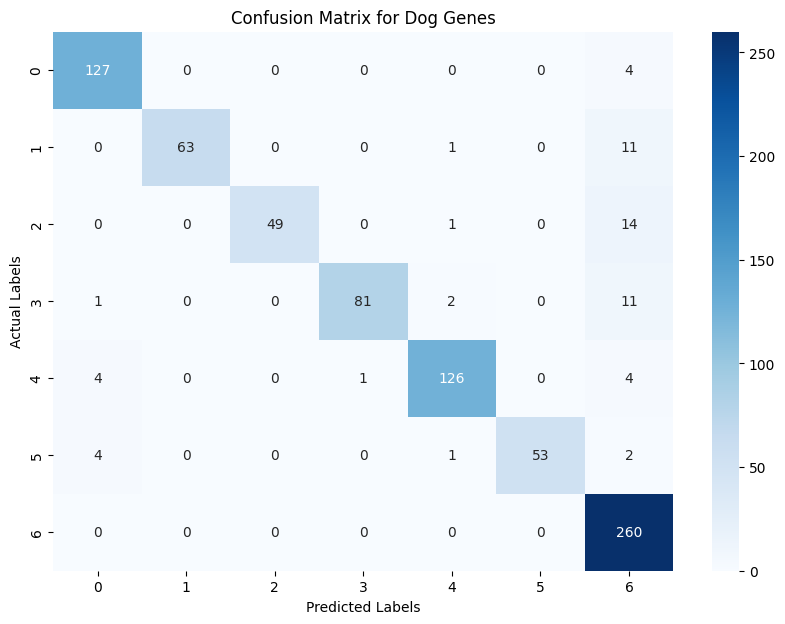

In [ ]:
# Calculate performance metrics
accuracy, precision, recall, f1 = get_metrics(y_d, y_pred_dog)


# Display the confusion matrix with seaborn for better visualization
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues')
plt.title('Confusion Matrix for Dog Genes')
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.show()




In [ ]:
# Display the classification report
print("\nClassification Report:\n")
print(classification_report(y_d, y_pred_dog))


Classification Report:

              precision    recall  f1-score   support

           0       0.93      0.97      0.95       131
           1       1.00      0.84      0.91        75
           2       1.00      0.77      0.87        64
           3       0.99      0.85      0.92        95
           4       0.96      0.93      0.95       135
           5       1.00      0.88      0.94        60
           6       0.85      1.00      0.92       260

    accuracy                           0.93       820
   macro avg       0.96      0.89      0.92       820
weighted avg       0.93      0.93      0.93       820



## NB with optimizer (AHA _PSO)

In [117]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Use the hybrid optimizer to find the best centroids
best_centroids, best_fitness = hybrid_aha_pso(X_dog, y_d, n_clusters=3, aha_iterations=5, aha_hummingbirds=3, pso_iterations=3, pso_particles=3
                                              )
print(f"Best Fitness Overall (ARI): {-best_fitness}")

Best Fitness Overall (ARI): 0.0013146786247025906


/usr/local/lib/python3.10/dist-packages/sklearn/naive_bayes.py:624: FutureWarning:

The default value for `force_alpha` will change to `True` in 1.4. To suppress this warning, manually set the value of `force_alpha`.

/usr/local/lib/python3.10/dist-packages/sklearn/naive_bayes.py:633: UserWarning:

alpha too small will result in numeric errors, setting alpha = 1.0e-10. Use `force_alpha=True` to keep alpha unchanged.



Confusion matrix

Predicted   0   1   2    3    4   5    6
Actual                                  
0          94   0   0    0    0   0    8
1           0  97   0    0    0   0    9
2           0   0  78    0    0   0    0
3           0   0   0  122    0   0    3
4           0   0   0    0  139   0   10
5           0   0   0    0    0  49    2
6           0   0   0    0    0   0  265
accuracy = 0.963 
precision = 0.967 
recall = 0.963 
f1 = 0.964


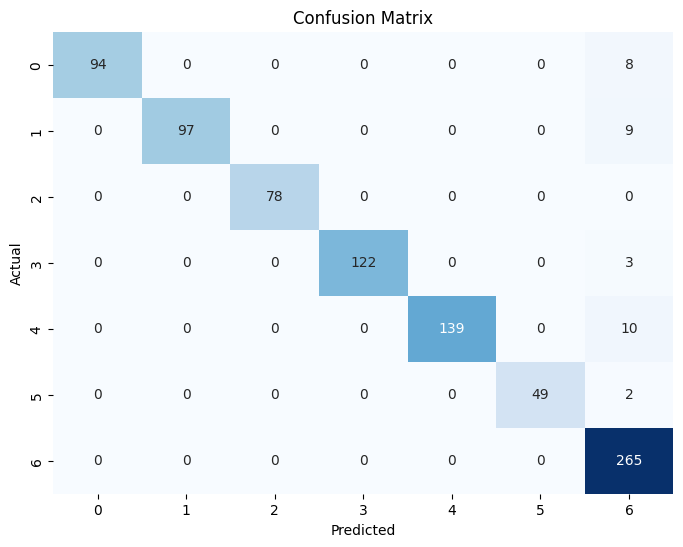

In [138]:
# Train Naive Bayes Classifier using the optimized centroids
classifier = MultinomialNB(alpha=best_centroids[0][0])
classifier.fit(X_dog, y_d)
y_pred = classifier.predict(X_test)

# Evaluate the model
def get_metrics(y_test, y_predicted):
    accuracy = accuracy_score(y_test, y_predicted)
    precision = precision_score(y_test, y_predicted, average='weighted')
    recall = recall_score(y_test, y_predicted, average='weighted')
    f1 = f1_score(y_test, y_predicted, average='weighted')
    return accuracy, precision, recall, f1

accuracy, precision, recall, f1 = get_metrics(y_test, y_pred)
print("Confusion matrix\n")
conf_matrix = pd.crosstab(pd.Series(y_test, name='Actual'), pd.Series(y_pred, name='Predicted'))
print(conf_matrix)
print("accuracy = %.3f \nprecision = %.3f \nrecall = %.3f \nf1 = %.3f" % (accuracy, precision, recall, f1))

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Initialize the Random Forest classifier
classifier_rf = RandomForestClassifier(n_estimators=1000, random_state=42)

# Train the classifier on the training data
classifier_rf.fit(X_train, y_train)

# Predict using the trained Random Forest classifier
y_pred_dog_rf = classifier_rf.predict(X_dog)


Confusion Matrix

Predicted    0   1   2   3    4   5    6
Actual                                  
0          114   0   0   3    3   0   11
1            0  59   0   2    0   0   14
2            0   0  55   0    0   0    9
3            0   0   0  77    2   0   16
4            2   1   0   4  109   0   19
5           12   0   0   1    0  30   17
6            0   0   0   1    0   0  259


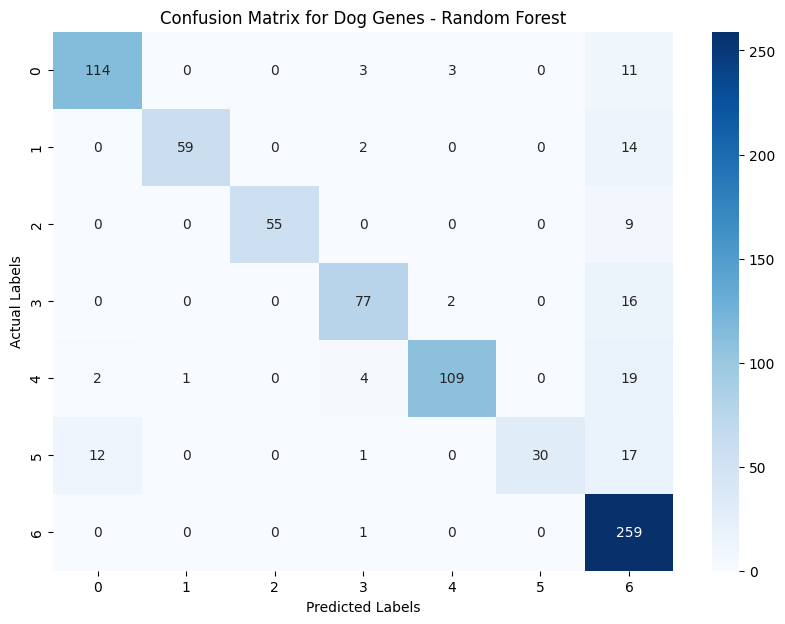

In [ ]:
# Calculate performance metrics
accuracy_rf, precision_rf, recall_rf, f1_rf = get_metrics(y_d, y_pred_dog_rf)

# Display the confusion matrix
conf_matrix = pd.crosstab(pd.Series(y_d, name='Actual'), pd.Series(y_pred_dog_rf, name='Predicted'))
print("Confusion Matrix\n")
print(conf_matrix)

# Display the confusion matrix with seaborn for better visualization
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues')
plt.title('Confusion Matrix for Dog Genes - Random Forest')
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.show()



In [ ]:
# Print the metrics
print("Random Forest Metrics:")
print(f"accuracy = {accuracy_rf:.3f}")
print(f"precision = {precision_rf:.3f}")
print(f"recall = {recall_rf:.3f}")
print(f"f1 = {f1_rf:.3f}")

# Display the classification report
print("\nClassification Report:\n")
print(classification_report(y_d, y_pred_dog_rf))

Random Forest Metrics:
accuracy = 0.857
precision = 0.880
recall = 0.857
f1 = 0.855

Classification Report:

              precision    recall  f1-score   support

           0       0.89      0.87      0.88       131
           1       0.98      0.79      0.87        75
           2       1.00      0.86      0.92        64
           3       0.88      0.81      0.84        95
           4       0.96      0.81      0.88       135
           5       1.00      0.50      0.67        60
           6       0.75      1.00      0.86       260

    accuracy                           0.86       820
   macro avg       0.92      0.80      0.85       820
weighted avg       0.88      0.86      0.85       820



## RF with optimizer (AHA _PSO)

In [157]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Use the hybrid optimizer to find the best centroids
best_centroids, best_fitness = hybrid_aha_pso(X_dog, y_d, n_clusters=4, aha_iterations=10, aha_hummingbirds=4, pso_iterations=4, pso_particles=3)
print(f"Best Fitness Overall (ARI): {-best_fitness}")



Best Fitness Overall (ARI): 0.0037250490359148365


Confusion matrix

Predicted   0   1   2   3   4   5    6
Actual                                
0          28   0   0   0   0   0    0
1           0  39   0   0   0   0    0
2           0   0  27   0   0   0    0
3           0   0   0  43   0   0    0
4           0   0   0   0  52   0    0
5           0   0   0   0   0  29    0
6           0   0   0   0   0   0  119
accuracy = 1.000 
precision = 1.000 
recall = 1.000 
f1 = 1.000


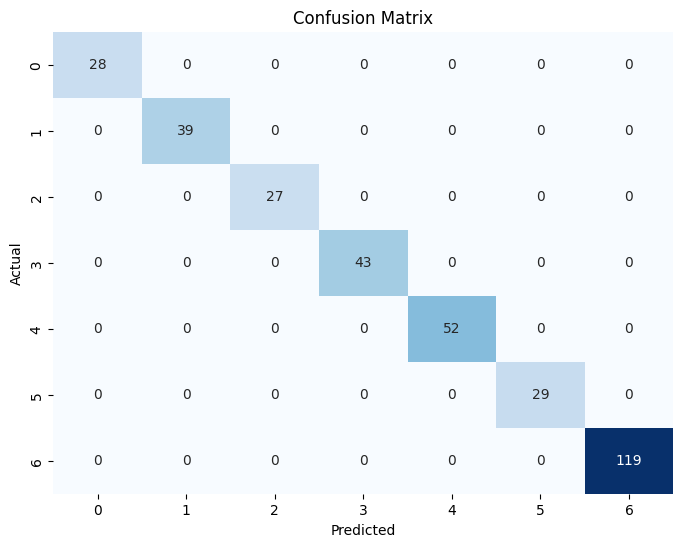

In [ ]:
# Train Random Forest Classifier using the optimized centroids
classifier = RandomForestClassifier(random_state=42)
classifier.fit(X_dog, y_d)
y_pred = classifier.predict(X_test)

# Evaluate the model
def get_metrics(y_test, y_predicted):
    accuracy = accuracy_score(y_test, y_predicted)
    precision = precision_score(y_test, y_predicted, average='weighted')
    recall = recall_score(y_test, y_predicted, average='weighted')
    f1 = f1_score(y_test, y_predicted, average='weighted')
    return accuracy, precision, recall, f1

accuracy, precision, recall, f1 = get_metrics(y_test, y_pred)
print("Confusion matrix\n")
conf_matrix = pd.crosstab(pd.Series(y_test, name='Actual'), pd.Series(y_pred, name='Predicted'))
print(conf_matrix)
print("accuracy = %.3f \nprecision = %.3f \nrecall = %.3f \nf1 = %.3f" % (accuracy, precision, recall, f1))

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


## SVM

In [ ]:
# Initialize the SVM classifier
classifier_svm = SVC(kernel='linear', random_state=42, C=1.0)  # Linear kernel and default C value

# Train the classifier on the training data
classifier_svm.fit(X_train, y_train)

# Predict using the trained SVM classifier
y_pred_dog_svm = classifier_svm.predict(X_dog)


Confusion Matrix

Predicted   0   1   2   3    4   5    6
Actual                                 
0          81   0   2   0   39   2    7
1           0  62   0   0    6   1    6
2           0   0  53   0    7   2    2
3           0   0   0  41   46   0    8
4           0   0   0   2  117   0   16
5           0   1   0   0    7  48    4
6           0   0   0   0    6   2  252


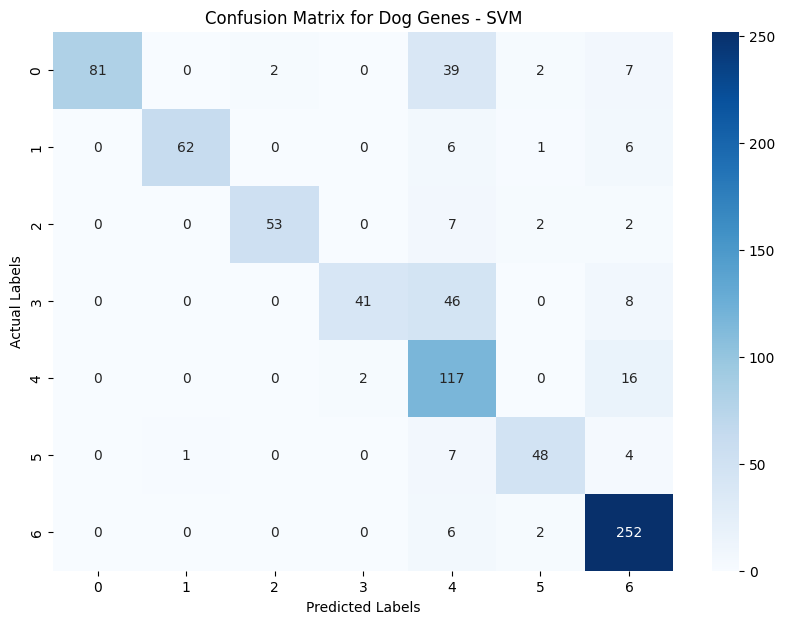

In [ ]:

# Calculate performance metrics
accuracy_svm, precision_svm, recall_svm, f1_svm = get_metrics(y_d, y_pred_dog_svm)

# Display the confusion matrix
conf_matrix = pd.crosstab(pd.Series(y_d, name='Actual'), pd.Series(y_pred_dog_svm, name='Predicted'))
print("Confusion Matrix\n")
print(conf_matrix)

# Display the confusion matrix with seaborn for better visualization
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues')
plt.title('Confusion Matrix for Dog Genes - SVM')
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.show()



In [ ]:
# Print the metrics
print("SVM Metrics:")
print(f"accuracy = {accuracy_svm:.3f}")
print(f"precision = {precision_svm:.3f}")
print(f"recall = {recall_svm:.3f}")
print(f"f1 = {f1_svm:.3f}")



SVM Metrics:
accuracy = 0.798
precision = 0.855
recall = 0.798
f1 = 0.798


In [ ]:
# Display the classification report
print("\nClassification Report:\n")
print(classification_report(y_d, y_pred_dog_svm))


Classification Report:

              precision    recall  f1-score   support

           0       1.00      0.62      0.76       131
           1       0.98      0.83      0.90        75
           2       0.96      0.83      0.89        64
           3       0.95      0.43      0.59        95
           4       0.51      0.87      0.64       135
           5       0.87      0.80      0.83        60
           6       0.85      0.97      0.91       260

    accuracy                           0.80       820
   macro avg       0.88      0.76      0.79       820
weighted avg       0.85      0.80      0.80       820



# CHIMP

## NB

In [151]:
# Splitting the human dataset into the training set and test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_chimp,
                                                    y_c,
                                                    test_size = 0.20,
                                                    random_state=42)

In [ ]:
# Predicting the chimp sequences
y_pred_chimp = classifier.predict(X_chimp)

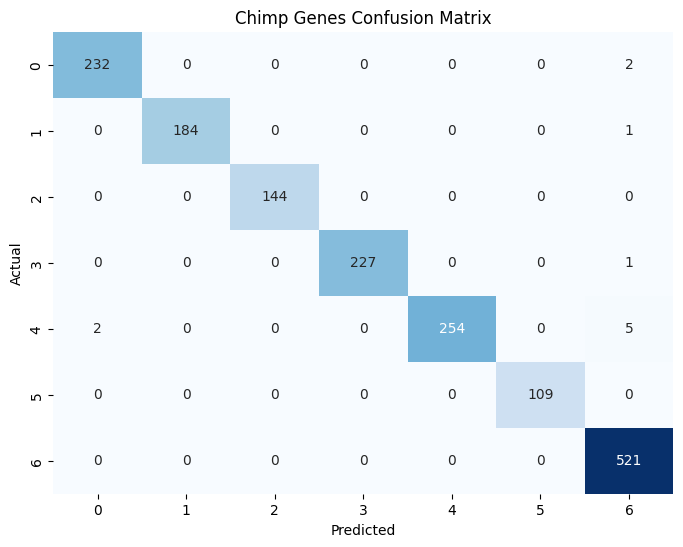


Chimp Genes Metrics:
accuracy = 0.993 
precision = 0.994 
recall = 0.993 
f1 = 0.993


In [ ]:
# Calculate the confusion matrix for chimp genes
conf_matrix_chimp = pd.crosstab(pd.Series(y_c, name='Actual'), pd.Series(y_pred_chimp, name='Predicted'))

# Plot the confusion matrix for chimp genes using Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_chimp, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Chimp Genes Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Evaluate performance on chimp genes
accuracy_chimp, precision_chimp, recall_chimp, f1_chimp = get_metrics(y_c, y_pred_chimp)

print("\nChimp Genes Metrics:")
print("accuracy = %.3f \nprecision = %.3f \nrecall = %.3f \nf1 = %.3f" % (accuracy_chimp, precision_chimp, recall_chimp, f1_chimp))

In [ ]:
# performance on chimp genes
print("Confusion matrix\n")
print(pd.crosstab(pd.Series(y_c, name='Actual'), pd.Series(y_pred_chimp, name='Predicted')))
accuracy, precision, recall, f1 = get_metrics(y_c, y_pred_chimp)


Confusion matrix

Predicted    0    1    2    3    4    5    6
Actual                                      
0          232    0    0    0    0    0    2
1            0  184    0    0    0    0    1
2            0    0  144    0    0    0    0
3            0    0    0  227    0    0    1
4            2    0    0    0  254    0    5
5            0    0    0    0    0  109    0
6            0    0    0    0    0    0  521


## SVC

In [ ]:
# Support Vector Machine (SVM)
svm_classifier = SVC(kernel='linear', random_state=42)
svm_classifier.fit(X_train, y_train)
y_pred_svm = svm_classifier.predict(X_test)

# Evaluate other models
accuracy_rf, precision_rf, recall_rf, f1_rf = get_metrics(y_test, y_pred_rf)
accuracy_svm, precision_svm, recall_svm, f1_svm = get_metrics(y_test, y_pred_svm)


print("\nSVM Metrics:")
print("accuracy = %.3f \nprecision = %.3f \nrecall = %.3f \nf1 = %.3f" % (accuracy_svm, precision_svm, recall_svm, f1_svm))


SVM Metrics:
accuracy = 0.872 
precision = 0.899 
recall = 0.872 
f1 = 0.872



Classification Report for SVM:
              precision    recall  f1-score   support

           0       0.88      0.75      0.81        28
           1       1.00      0.87      0.93        39
           2       1.00      0.89      0.94        27
           3       1.00      0.88      0.94        43
           4       0.98      0.77      0.86        52
           5       1.00      0.62      0.77        29
           6       0.75      1.00      0.86       119

    accuracy                           0.87       337
   macro avg       0.94      0.83      0.87       337
weighted avg       0.90      0.87      0.87       337



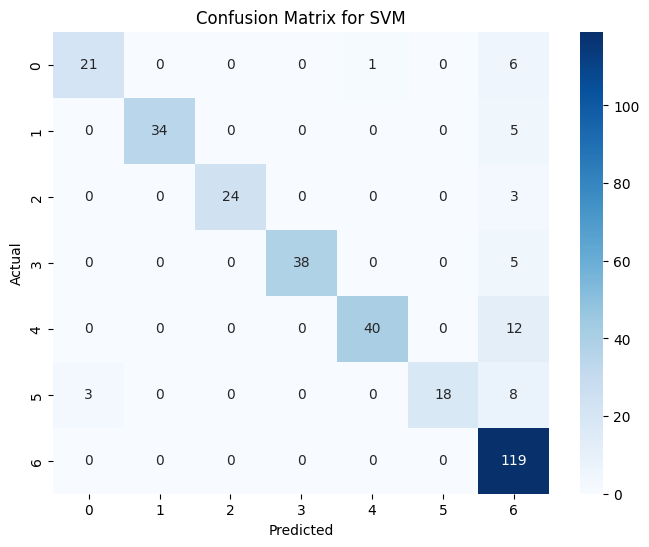

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Print Classification Report
print("\nClassification Report for SVM:")
print(classification_report(y_test, y_pred_svm))

# Plot Confusion Matrix for SVM
cm_svm = confusion_matrix(y_test, y_pred_svm)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_svm, annot=True, fmt="d", cmap="Blues", xticklabels=range(7), yticklabels=range(7))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix for SVM")
plt.show()

## Random


Random Forest Metrics:
accuracy = 0.852 
precision = 0.886 
recall = 0.852 
f1 = 0.850

Classification Report for Random Forest Classifier:
              precision    recall  f1-score   support

           0       0.80      0.71      0.75        28
           1       1.00      0.85      0.92        39
           2       1.00      1.00      1.00        27
           3       1.00      0.84      0.91        43
           4       1.00      0.65      0.79        52
           5       1.00      0.62      0.77        29
           6       0.73      1.00      0.84       119

    accuracy                           0.85       337
   macro avg       0.93      0.81      0.85       337
weighted avg       0.89      0.85      0.85       337



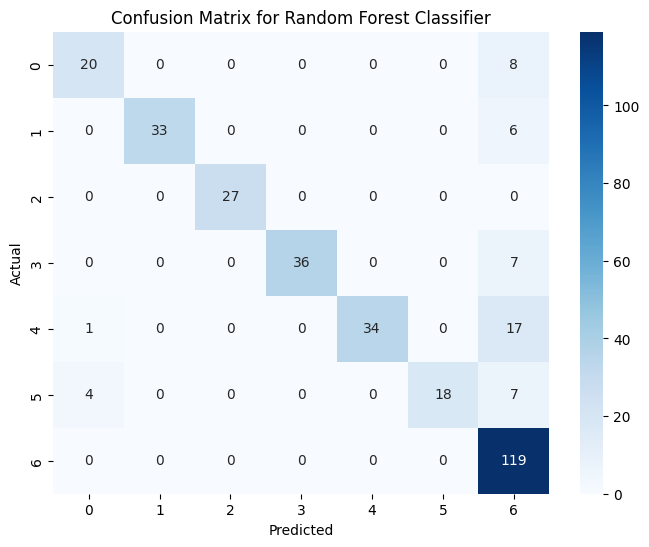

In [ ]:
# Random Forest Classifier
rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(X_train, y_train)
y_pred_rf = rf_classifier.predict(X_test)

# Evaluate Random Forest Classifier
accuracy_rf, precision_rf, recall_rf, f1_rf = get_metrics(y_test, y_pred_rf)

# Print Random Forest Metrics
print("\nRandom Forest Metrics:")
print("accuracy = %.3f \nprecision = %.3f \nrecall = %.3f \nf1 = %.3f" % (accuracy_rf, precision_rf, recall_rf, f1_rf))

# Print Classification Report for Random Forest Classifier
print("\nClassification Report for Random Forest Classifier:")
print(classification_report(y_test, y_pred_rf))

# Plot Confusion Matrix for Random Forest Classifier
cm_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf, annot=True, fmt="d", cmap="Blues", xticklabels=range(7), yticklabels=range(7))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix for Random Forest Classifier")
plt.show()


## RF with optimizer (AHA _PSO)

In [152]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Use the hybrid optimizer to find the best centroids
best_centroids, best_fitness = hybrid_aha_pso(X_chimp, y_c, n_clusters=4, aha_iterations=8, aha_hummingbirds=3, pso_iterations=3, pso_particles=3)
print(f"Best Fitness Overall (ARI): {-best_fitness}")



Best Fitness Overall (ARI): 0.0055982255875169865


Confusion matrix

Predicted   0   1   2   3   4   5    6
Actual                                
0          28   0   0   0   0   0    0
1           0  39   0   0   0   0    0
2           0   0  27   0   0   0    0
3           0   0   0  43   0   0    0
4           0   0   0   0  52   0    0
5           0   0   0   0   0  29    0
6           0   0   0   0   0   0  119
accuracy = 1.000 
precision = 1.000 
recall = 1.000 
f1 = 1.000


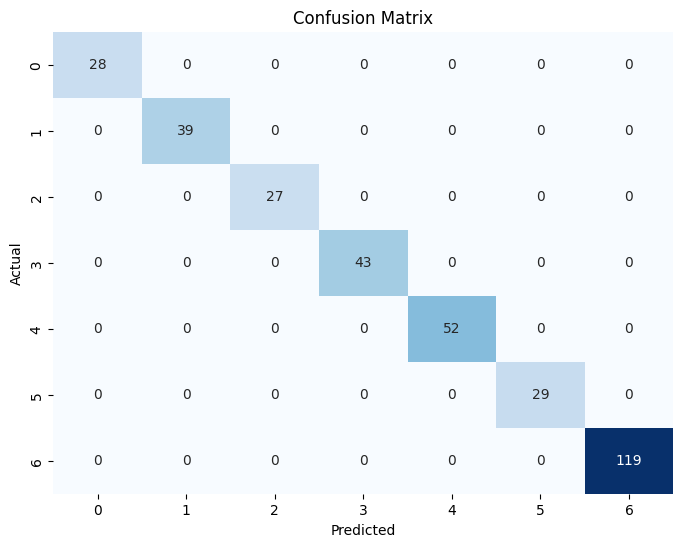

In [153]:
# Train Random Forest Classifier using the optimized centroids
classifier = RandomForestClassifier(random_state=42)
classifier.fit(X_chimp, y_c)
y_pred = classifier.predict(X_test)

# Evaluate the model
def get_metrics(y_test, y_predicted):
    accuracy = accuracy_score(y_test, y_predicted)
    precision = precision_score(y_test, y_predicted, average='weighted')
    recall = recall_score(y_test, y_predicted, average='weighted')
    f1 = f1_score(y_test, y_predicted, average='weighted')
    return accuracy, precision, recall, f1

accuracy, precision, recall, f1 = get_metrics(y_test, y_pred)
print("Confusion matrix\n")
conf_matrix = pd.crosstab(pd.Series(y_test, name='Actual'), pd.Series(y_pred, name='Predicted'))
print(conf_matrix)
print("accuracy = %.3f \nprecision = %.3f \nrecall = %.3f \nf1 = %.3f" % (accuracy, precision, recall, f1))

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


# Roc

In [ ]:
from sklearn.preprocessing import label_binarize
y_pred = label_binarize(y_pred, classes=[0,1,2,3,4,5,6])
y_test = label_binarize(y_test, classes=[0,1,2,3,4,5,6])
y_pred_chimp = label_binarize(y_pred_chimp, classes=[0,1,2,3,4,5,6])
y_pred_dog = label_binarize(y_pred_dog, classes=[0,1,2,3,4,5,6])
y_c = label_binarize(y_c, classes=[0,1,2,3,4,5,6])
y_d = label_binarize(y_d, classes=[0,1,2,3,4,5,6])

In [ ]:
from sklearn.metrics import roc_curve, auc
from itertools import cycle
def get_roc(y_t,y_pd,val):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(7):
        fpr[i], tpr[i], _ = roc_curve(y_t[:, i], y_pd[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    lw=2
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue','red','blue','yellow'])
    for i, color in zip(range(7), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve {}'.format(val))
    plt.legend(loc="lower right")
    plt.show()

In [ ]:
def plot_roc_curve(fper, tper):
    plt.plot(fper, tper, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

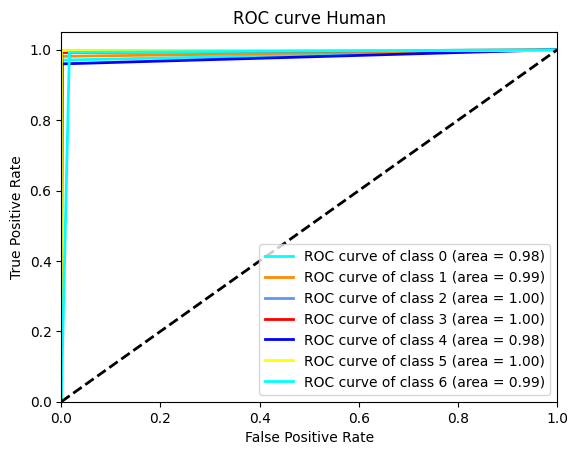

In [ ]:
get_roc(y_test,y_pred,'Human')


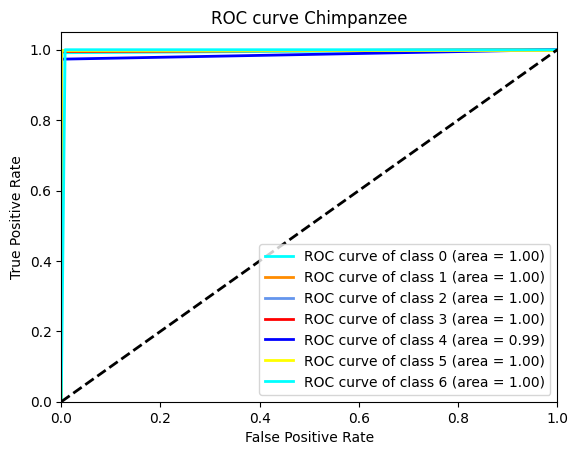

In [ ]:
get_roc(y_c,y_pred_chimp,'Chimpanzee')


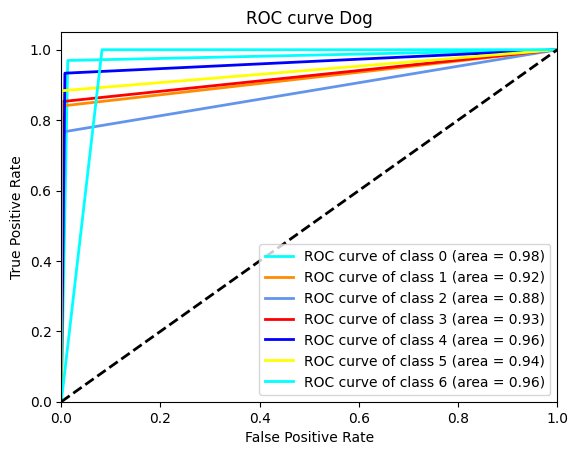

In [ ]:
get_roc(y_d,y_pred_dog,'Dog')

# all species

## svc

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

# Read data
human_df = pd.read_table('/content/human.txt')
chimp_df = pd.read_table('/content/chimpanzee.txt')
dog_df = pd.read_table('/content/dog.txt')

# Combine the three DataFrames into a single DataFrame
combined_df = pd.concat([human_df, chimp_df, dog_df], ignore_index=True)

# Create k-mers
combined_df['words'] = combined_df.apply(lambda x: getKmers(x['sequence']), axis=1)
combined_df['words'] = combined_df['sequence'].apply(lambda x: ' '.join(getKmers(x)))

# Convert k-mers into a bag-of-words representation
cv = CountVectorizer(ngram_range=(4, 4))
X_combined = cv.fit_transform(combined_df['words'])

# Extract labels
y_combined = combined_df['class'].values

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_combined, y_combined, test_size=0.2, random_state=42)

# Initialize the SVM classifier
classifier = SVC(kernel='linear')

# Train the classifier on the training data
classifier.fit(X_train, y_train)

# Make predictions on the test data
predictions = classifier.predict(X_test)

# Evaluate the performance
accuracy = accuracy_score(y_test, predictions)
report = classification_report(y_test, predictions)

print(f'Accuracy: {accuracy}')
print('Classification Report:')
print(report)


Accuracy: 0.9404502541757443
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.92      0.95       159
           1       1.00      0.91      0.95       163
           2       1.00      0.94      0.97       115
           3       0.98      0.94      0.96       196
           4       0.96      0.91      0.94       226
           5       0.99      0.84      0.90        85
           6       0.86      1.00      0.93       433

    accuracy                           0.94      1377
   macro avg       0.97      0.92      0.94      1377
weighted avg       0.95      0.94      0.94      1377



## Random forest

In [ ]:
# Initialize the Random Forest classifier with 1000 trees
classifier_rf = RandomForestClassifier(n_estimators=1000, random_state=42)

# Train the classifier on the training data
classifier_rf.fit(X_train, y_train)

# Make predictions on the test data
predictions_rf = classifier_rf.predict(X_test)

# Evaluate the performance
accuracy_rf = accuracy_score(y_test, predictions_rf)
report_rf = classification_report(y_test, predictions_rf)

print(f'Accuracy: {accuracy_rf}')
print('Classification Report:')
print(report_rf)


Accuracy: 0.9462599854756718
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.92      0.95       159
           1       1.00      0.91      0.96       163
           2       1.00      0.94      0.97       115
           3       0.82      0.99      0.90       196
           4       1.00      0.92      0.95       226
           5       1.00      0.84      0.91        85
           6       0.94      0.99      0.96       433

    accuracy                           0.95      1377
   macro avg       0.96      0.93      0.94      1377
weighted avg       0.95      0.95      0.95      1377



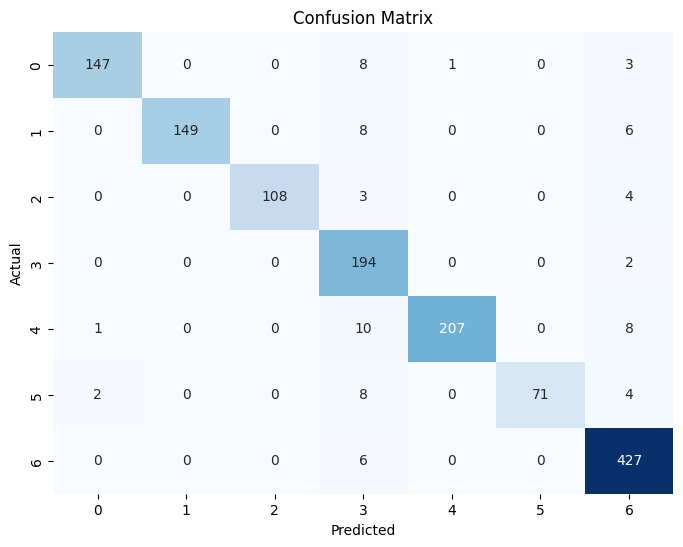

In [ ]:
# Calculate the confusion matrix
conf_matrix = pd.crosstab(pd.Series(y_test, name='Actual'), pd.Series( predictions_rf, name='Predicted'))

# Plot the confusion matrix using Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import shap


# Preprocessing: Check and handle missing data or incorrect class values
for df in [human, chimp, dog]:
    df['sequence'].replace('', np.nan, inplace=True)
    df.dropna(subset=['sequence', 'class'], inplace=True)
    df['class'] = df['class'].apply(lambda x: x if x <= 6 else np.nan)
    df.dropna(subset=['class'], inplace=True)

# Convert sequences to k-mers
def getKmers(sequence, size=6):
    return [sequence[x:x+size].lower() for x in range(len(sequence) - size + 1)]

for df in [human, chimp, dog]:
    df['kmers'] = df.apply(lambda x: getKmers(x['sequence']), axis=1)

# Feature extraction using k-mers (example with human dataset)
human['kmers_str'] = [' '.join(map(str, l)) for l in human['kmers']]
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer()
X = cv.fit_transform(human['kmers_str'])
y = human['class']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature selection using VarianceThreshold
selector = VarianceThreshold(threshold=0.1)
X_train_selected = selector.fit_transform(X_train)
X_test_selected = selector.transform(X_test)

# Ensemble Learning: Train multiple models
model1 = RandomForestClassifier()
model2 = GradientBoostingClassifier()
model3 = LogisticRegression(max_iter=1000)

model1.fit(X_train_selected, y_train)
model2.fit(X_train_selected, y_train)
model3.fit(X_train_selected, y_train)

pred1 = model1.predict(X_test_selected)
pred2 = model2.predict(X_test_selected)
pred3 = model3.predict(X_test_selected)

# Averaging Unit: Combine predictions using weights
weights = [0.4, 0.3, 0.3]
final_pred = (weights[0]*pred1 + weights[1]*pred2 + weights[2]*pred3).round()

# Evaluate accuracy
accuracy = accuracy_score(y_test, final_pred)
print(f'Ensemble model accuracy: {accuracy}')

Ensemble model accuracy: 0.8207762557077626


In [19]:
import numpy as np

class WaOA:
    def __init__(self, fitness_function, bounds, n_particles=30, n_iterations=100):
        self.fitness_function = fitness_function
        self.bounds = bounds
        self.n_particles = n_particles
        self.n_iterations = n_iterations
        self.dim = len(bounds)
        self.init_particles()

    def init_particles(self):
        self.particles = np.random.rand(self.n_particles, self.dim)
        self.velocities = np.random.rand(self.n_particles, self.dim)
        self.best_positions = np.copy(self.particles)
        self.best_scores = np.array([self.fitness_function(p) for p in self.particles])
        self.global_best_position = self.best_positions[np.argmin(self.best_scores)]

    def optimize(self):
        for _ in range(self.n_iterations):
            for i in range(self.n_particles):
                self.particles[i] += self.velocities[i]
                self.particles[i] = np.clip(self.particles[i], self.bounds[:, 0], self.bounds[:, 1])
                score = self.fitness_function(self.particles[i])
                if score < self.best_scores[i]:
                    self.best_scores[i] = score
                    self.best_positions[i] = self.particles[i]
                    if score < min(self.best_scores):
                        self.global_best_position = self.particles[i]
            # Update velocities here using WaOA-specific rules

        return self.global_best_position


In [21]:
!pip install pyswarms

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 3.4 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import pyswarms as ps
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, f1_score

# Define the get_metrics function
def get_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    return accuracy, precision, recall, f1

# Define the objective function to minimize
def objective_function(params):
    # The params array is 2D: (n_particles, n_parameters)
    n_particles = params.shape[0]
    j = np.zeros(n_particles)  # Initialize an array to store the objective function values

    for i in range(n_particles):
        # Extract parameters for particle i
        alpha = params[i, 0]
        model = MultinomialNB(alpha=alpha)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        _, _, _, f1 = get_metrics(y_test, y_pred)
        j[i] = -f1  # Negative F1 score for minimization

    return j

# Set up hyperparameters for PSO
options = {'c1': 0.5, 'c2': 0.3, 'w': 0.9}

# Create bounds
max_bound = np.array([1.0])  # Max value for alpha
min_bound = np.array([0.01])  # Min value for alpha
bounds = (min_bound, max_bound)

# Initialize PSO optimizer
optimizer = ps.single.GlobalBestPSO(n_particles=10, dimensions=1, options=options, bounds=bounds)

# Perform optimization
cost, pos = optimizer.optimize(objective_function, iters=10)

# Print the optimized hyperparameters
print("Optimized alpha:", pos[0])


2024-08-06 11:26:33,436 - pyswarms.single.global_best - INFO - Optimize for 10 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|10/10, best_cost=-0.987
2024-08-06 11:26:54,033 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -0.9874541441866648, best pos: [0.41532378]


Optimized alpha: 0.4153237794273166


Optimized model performance:
Accuracy = 0.987
Precision = 0.988
Recall = 0.987
F1 Score = 0.987


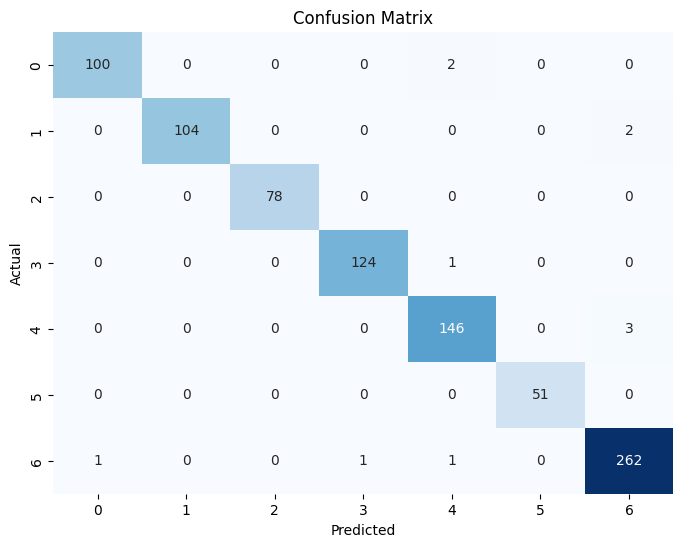

In [ ]:
# Initialize and train the model with optimized alpha
optimized_alpha = pos[0]
model_optimized = MultinomialNB(alpha=optimized_alpha)
model_optimized.fit(X_train, y_train)

# Predict and evaluate
y_pred_optimized = model_optimized.predict(X_test)
accuracy, precision, recall, f1 = get_metrics(y_test, y_pred_optimized)

print("Optimized model performance:")
print(f"Accuracy = {accuracy:.3f}")
print(f"Precision = {precision:.3f}")
print(f"Recall = {recall:.3f}")
print(f"F1 Score = {f1:.3f}")

# Optionally, plot the confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt

conf_matrix = pd.crosstab(pd.Series(y_test, name='Actual'), pd.Series(y_pred_optimized, name='Predicted'))
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
